<h1>IMPORT LIBRARY</h1>

In [37]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

Kode di atas digunakan untuk mengimpor berbagai pustaka yang diperlukan untuk membaca data, mengekstrak fitur, membangun model klasifikasi, dan mengevaluasi kinerjanya. Pustaka os digunakan untuk menjelajahi direktori dan mengakses file citra retina, sementara cv2 (OpenCV) berperan dalam proses pembacaan dan pengolahan gambar. Untuk visualisasi data dan hasil klasifikasi, digunakan matplotlib.pyplot dan seaborn. Manipulasi data numerik serta data dalam bentuk tabel dilakukan dengan bantuan numpy dan pandas. Pembagian dataset menjadi data pelatihan dan pengujian dilakukan menggunakan fungsi train_test_split, sedangkan cross_val_predict digunakan untuk melakukan validasi silang dalam proses prediksi.Evaluasi performa model klasifikasi dilakukan dengan berbagai metrik seperti akurasi, presisi, recall, f1-score, dan confusion matrix, yang disediakan oleh modul sklearn.metrics. Untuk mengekstraksi fitur tekstur dari gambar, digunakan metode GLCM (Gray-Level Co-occurrence Matrix) melalui fungsi graycomatrix dan graycoprops dari pustaka skimage.feature, serta penghitungan entropi menggunakan fungsi entropy dari scipy.stats. Tiga algoritma klasifikasi yang diterapkan dalam kode ini adalah Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN), yang semuanya berasal dari pustaka sklearn.

<h1>MEMBACA DATASET</h1>

In [38]:
data = []
labels = []
file_name = []

# Loop melalui setiap subfolder (normal-cecum, polyps, ulcerative-colitis)
for sub_folder in os.listdir("dataset/"):
    sub_folder_path = os.path.join("dataset/", sub_folder)
    
    # Loop melalui setiap file gambar di subfolder
    for filename in os.listdir(sub_folder_path):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv2.imread(img_path) # Baca gambar
        if img is None:  # Skip jika gambar corrupt
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (512, 512)) #Resize gambar ke ukuran tetap agar bisa di-convert ke numpy array

        # Simpan ke list
        data.append(img_resized)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

        
data = np.array(data)
labels = np.array(labels)

Kode di atas digunakan untuk memuat dan memproses citra usus besar dari dataset yang tersusun dalam struktur direktori berdasarkan label kelas. Terdapat empat kategori label yang digunakan, yaitu normal, polyps dan ulcerative-colitis. Setiap kategori diwakili oleh sebuah subfolder di dalam direktori dataset\, dan masing-masing berisi gambar retina yang termasuk dalam kategori tersebut. Program membaca gambar-gambar di dalamnya menggunakan OpenCV. Jika gambar berhasil dimuat, program mengubah warna citra menjadi grayscale agar lebih mudah untuk melakukan preprocessing. Gambar tersebut kemudian diubah ukurannya menjadi 512x512 piksel untuk menyamakan semua ukuran dataset sehingga lebih mudah untuk dianalisis.

<h1>PREPROCESSING</h1>

In [ ]:
def median(imageCitra):
    sort_image = sorted(imageCitra.flatten())
    
    if(len(imageCitra.flatten()) % 2 == 0):
        index_median1 = len(imageCitra.flatten())/2 - 1
        index_median2 = len(imageCitra.flatten())/2 
        
        return (sort_image[index_median1] + sort_image[index_median2])/2
    else:
        index_median1 = len(imageCitra.flatten())//2
        
        return (sort_image[index_median1])
    
def filteringCitra(imageCitra, kernel_size, filter):
    citra_height, citra_width = imageCitra.shape
    pad = kernel_size // 2

    padded_image = np.pad(imageCitra, pad_width=pad, mode='edge')

    result = np.zeros((citra_height, citra_width))

    for i in range(citra_height):
        for j in range(citra_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            if(filter == "mean"):
                result[i][j] = np.sum(region)/(kernel_size*kernel_size)
            elif(filter == "modus"):
                result[i][j] = modus(region)
            elif(filter == "median"):
                result[i][j] = median(region)
                
    return result

def convo(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result


sharpen_kernel = np.array([  [-1, -1, -1],
                             [-1,  9, -1],
                             [-1, -1, -1]])

def thresholding(imageCitra, threshold, min_val, max_val):
    imageCitra = imageCitra.astype(np.uint8)
    result = np.where(imageCitra <= threshold, max_val, min_val).astype(np.uint8)
    
    return result

def dilasi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.any(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def erosi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.all(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def opening(gambar, kernel):
    eroded = erosi(gambar, kernel)
    opened = dilasi(eroded, kernel)
    return opened.astype(np.uint8)

def closing(gambar, kernel):
    dilated = dilasi(gambar, kernel)
    closed = erosi(dilated, kernel)
    return closed.astype(np.uint8)

def masking(channel, mask_median):
    objek = channel.copy()
    objek[mask_median == 0] = 0 

    return objek

kernelElips3x3 = np.array([[0, 1, 0],
                           [1, 1, 1],
                           [0, 1, 0]], dtype=np.uint8)

Kode di atas terdiri dari beberapa fungsi yang digunakan untuk pengolahan citra grayscale dengan tujuan peningkatan kualitas citra, pengurangan noise, penajaman, serta operasi morfologi seperti dilasi, erosi, opening, dan closing. Kernel berbentuk elips 5x5 juga didefinisikan secara manual sebagai bagian dari operasi morfologi.
1. median, Fungsi ini digunakan untuk menghitung nilai median dari sebuah array 2D (patch citra lokal) dalam bentuk datar (flattened). Nilai median merupakan nilai tengah setelah semua piksel disortir. Jika jumlah elemen genap, maka median diambil dari rata-rata dua nilai tengah. Fungsi ini berperan sebagai inti dari filter median.
2. filteringCitra, Fungsi ini melakukan filtering citra menggunakan metode mean, median, atau modus sesuai parameter yang diberikan. Citra dipadding menggunakan mode 'edge' agar operasi dapat dilakukan hingga tepi. Untuk setiap piksel, jendela lokal sebesar kernel diambil, lalu dihitung nilai rata-rata (mean), median, atau modus sebagai nilai piksel baru. Fungsi ini berguna untuk reduksi noise serta mempertahankan struktur lokal citra, terutama saat menggunakan median.
3. convo, Fungsi ini melakukan konvolusi 2D antara citra dan kernel (matriks filter). Citra dipadding di tepi untuk menjaga dimensi keluaran tetap sama dengan input. Setiap piksel output dihasilkan dari penjumlahan perkalian elemen-elemen jendela lokal citra dengan kernel. Fungsi ini digunakan untuk berbagai operasi linear seperti penajaman atau blur, tergantung kernel yang digunakan.
4. thresholding, Fungsi ini menerapkan thresholding biner sederhana pada citra. Piksel dengan nilai kurang dari atau sama dengan threshold akan diatur ke max_val, sedangkan sisanya menjadi min_val. Biasanya digunakan untuk segmentasi objek dalam citra grayscale.
5. dilasi, Fungsi ini melakukan operasi dilasi biner. Citra input dinormalisasi ke biner (0 dan 1), lalu dipadding untuk menjaga ukuran. Untuk setiap piksel, jika ada setidaknya satu piksel dalam jendela kernel yang bernilai 1, maka hasilnya menjadi 1. Dilasi memperbesar area objek putih dan mengisi celah kecil pada objek.
6. erosi, Fungsi ini menjalankan operasi erosi biner. Berlawanan dengan dilasi, piksel hasil akan bernilai 1 hanya jika semua piksel dalam jendela kernel yang sesuai juga bernilai 1. Erosi berfungsi untuk mengecilkan objek dan menghilangkan noise kecil.
7. opening, Fungsi ini menggabungkan erosi diikuti dilasi, dikenal sebagai opening. Opening berguna untuk menghapus noise kecil sambil mempertahankan bentuk utama objek.
8. closing, Fungsi ini menjalankan dilasi lalu erosi, disebut sebagai closing. Closing digunakan untuk menutup lubang kecil dalam objek dan menyambungkan bagian objek yang terpisah.
9. masking, Fungsi ini melakukan masking terhadap suatu channel (lapisan citra) menggunakan citra biner mask_median. Piksel pada channel yang posisinya nol di mask_median akan diset menjadi nol. Fungsi ini bermanfaat untuk menyaring atau mengekstrak area tertentu dari citra.

<h1>FUNGSI PREPROCESSING</h1>

In [ ]:
def preprocess_3(img):
    img_median = filteringCitra(img, kernel_size=3, filter="median") 
    img_sharp = convo(img_median, sharpen_kernel)
    img_tresh = thresholding(img_sharp, 120, 255, 0)
    opened = opening(img_tresh, kernelElips3x3)
    closed = closing(opened, kernelElips3x3)
    erosed = erosi(closed, kernelElips3x3)
    masked = masking(img_median, erosed)
    return masked.astype(np.uint8)

Kode diatas merupakan rangkaian preprocessing citra grayscale yang dirancang untuk meningkatkan kualitas citra dan mengekstrak objek utama dari latar belakang. Langkah-langkahnya mencakup filtering, penajaman, segmentasi, dan morfologi, serta masking. Fungsi ini menghasilkan citra yang hanya menyisakan area objek penting, berdasarkan hasil segmentasi dan morfologi.

<h1>DATA PREPROCESSING</h1>

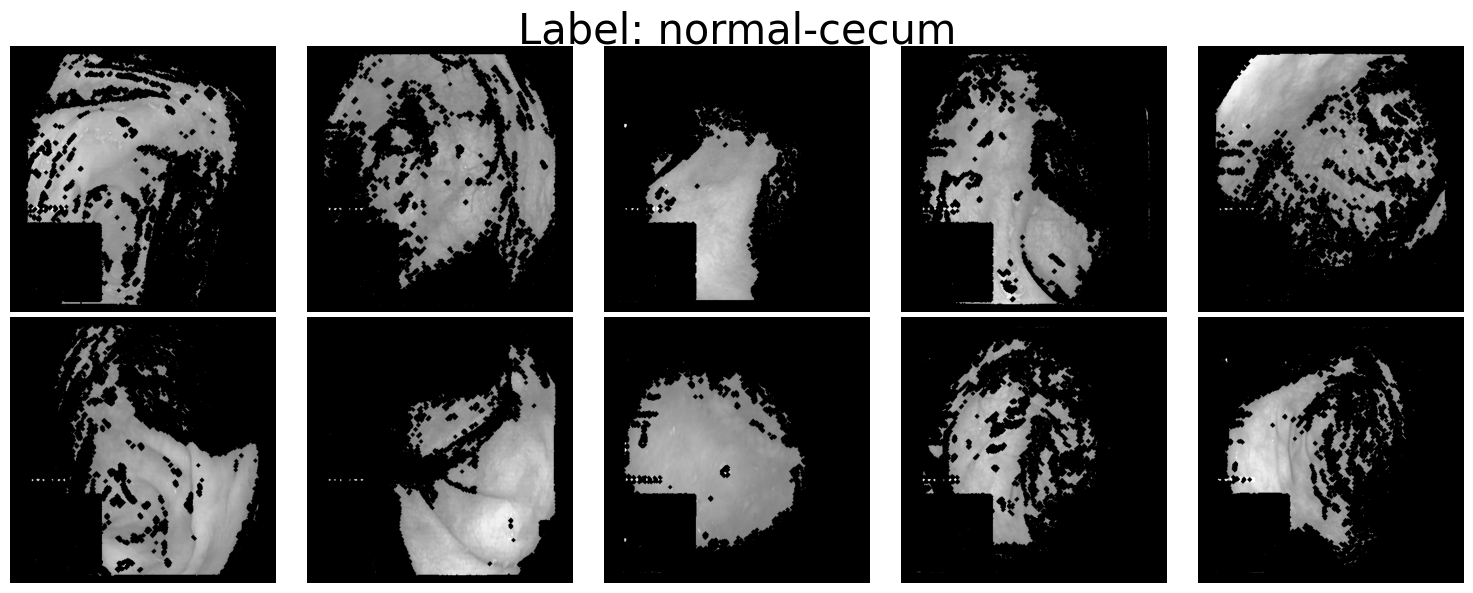

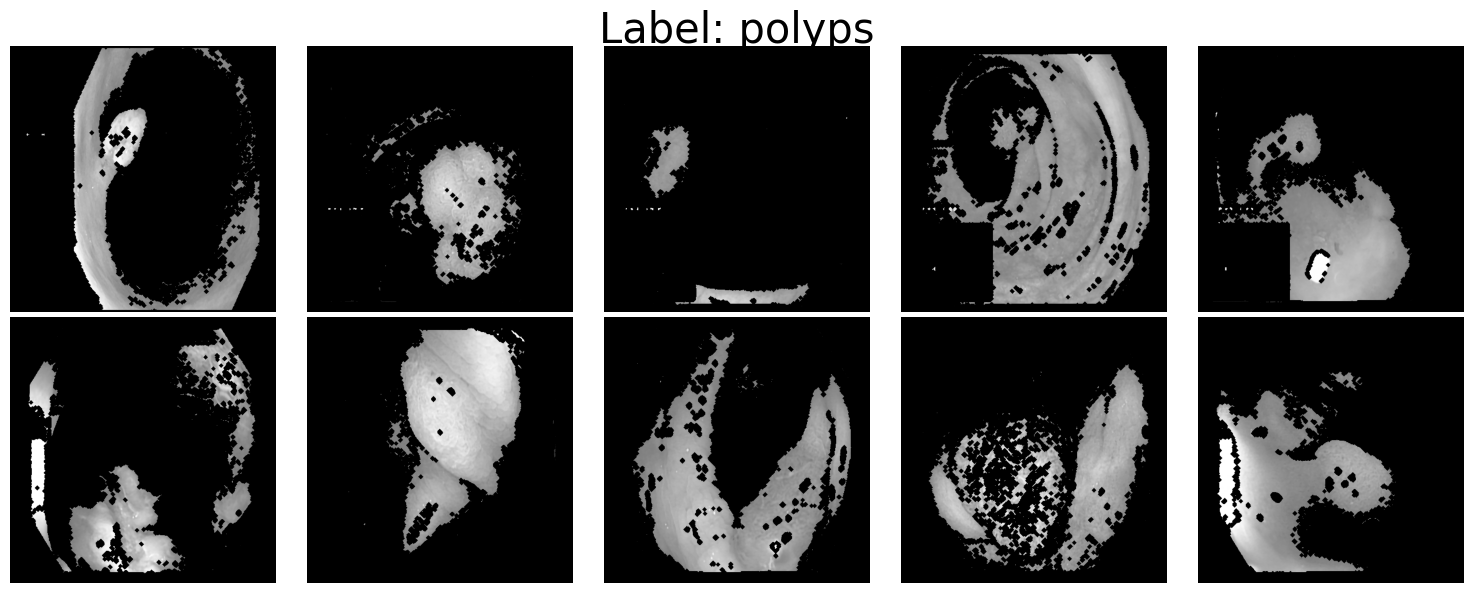

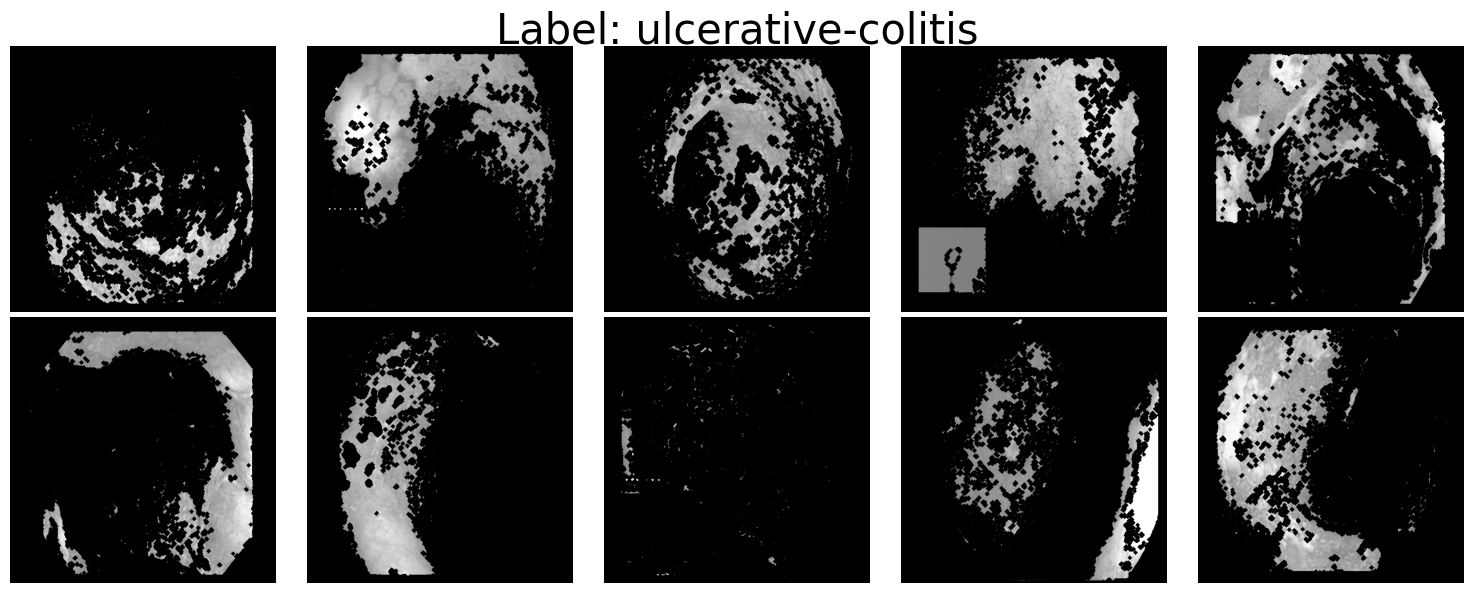

In [41]:
dataPreprocessed3 = [preprocess_3(img) for img in data] 
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
	
    # Buat grid 2x5 (cukup untuk 10 gambar, 2*5 = 10)
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Label: {label}', fontsize=30)
    
    for k in range(min(10, len(idxs))):
        row = k // 5
        col = k % 5
        ax = axs[row][col]
        ax.imshow(dataPreprocessed3[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

Kode di atas digunakan untuk melakukan preprocessing seluruh citra dalam dataset. Selanjutnya, kode mengelompokkan gambar berdasarkan label yang unik, dan untuk setiap label, ditampilkan maksimal 10 gambar hasil preprocessing dalam bentuk grid 2x5 menggunakan matplotlib. Proses ini bertujuan untuk memvisualisasikan dan memverifikasi hasil preprocessing, apakah citra yang dihasilkan sudah cukup bersih, tajam, dan fokus pada objek penting sesuai dengan labelnya.

<h1>EKSTRAKSI FITUR</h1>

In [42]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Kode di atas digunakan untuk menghitung matriks co-occurrence tingkat abu-abu (Gray-Level Co-occurrence Matrix atau GLCM) dari sebuah citra grayscale berdasarkan sudut tertentu. Fungsi menerima dua parameter: image, yaitu citra input dalam format array dua dimensi, dan derajat, yang merupakan sudut orientasi yang ingin digunakan dalam perhitungan GLCM (hanya menerima nilai 0, 45, 90, atau 135 derajat). Berdasarkan nilai derajat, fungsi mengonversinya menjadi radian sesuai standar, misalnya 0 derajat menjadi 0 radian, 45 derajat menjadi π/4, 90 derajat menjadi π/2, dan 135 derajat menjadi 3π/4. Jika sudut yang diberikan tidak valid, fungsi akan mengeluarkan ValueError.

In [43]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed3)):
    D0 = glcm(dataPreprocessed3[i], 0)
    D45 = glcm(dataPreprocessed3[i], 45)
    D90 = glcm(dataPreprocessed3[i], 90)
    D135 = glcm(dataPreprocessed3[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas digunakan untuk mendefinisikan beberapa fungsi untuk mengekstraksi fitur tekstur dari matriks Gray-Level Co-occurrence Matrix (GLCM) menggunakan pustaka skimage.feature dan fungsi entropi dari scipy.stats. Setiap fungsi menerima sebuah matriks GLCM sebagai input dan mengembalikan nilai tunggal yang merepresentasikan fitur tekstur tertentu.

Fungsi-fungsi tersebut meliputi:

1. correlation: Menghitung korelasi, yang menunjukkan derajat linearitas hubungan antara piksel tetangga dalam citra.
2. dissimilarity: Mengukur perbedaan intensitas antara piksel yang berpasangan, memberikan gambaran seberapa kontras tekstur.
3. homogenity: Mengukur keseragaman atau kehalusan tekstur, dengan nilai tinggi menunjukkan tekstur yang lebih seragam.
4. contrast: Mengukur variasi intensitas dalam citra, semakin tinggi nilai kontras, semakin tajam teksturnya.
5. ASM (Angular Second Moment): Menggambarkan tingkat keteraturan atau homogenitas matriks, juga dikenal sebagai energi kuadrat.
6. energy: Merupakan akar kuadrat dari ASM, merepresentasikan kekuatan tekstur.
7. entropyGlcm: Menghitung entropi dari matriks GLCM, yaitu ukuran kompleksitas atau ketidakpastian dalam tekstur citra.

In [44]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode diatas digunakan untuk mendefinisikan list kosong untuk setiap fitur tekstur yang akan diekstraksi pada tiap sudut, seperti kontras, dissimilarity, homogenitas, entropi, ASM, energi, dan korelasi. Kemudian, untuk setiap citra, fitur-fitur tersebut dihitung berdasarkan matriks GLCM yang telah disiapkan, dengan memanggil fungsi-fungsi seperti contrast(), dissimilarity(), homogenity(), entropyGlcm(), ASM(), energy(), dan correlation(). Nilai-nilai fitur yang diperoleh untuk masing-masing sudut derajat kemudian ditambahkan ke list yang sesuai.

In [45]:
for i in range(len(dataPreprocessed3)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode di atas digunakan untuk melakukan proses ekstraksi fitur korelasi tekstur dari citra hasil preprocessing yang telah dihitung sebelumnya dalam empat arah sudut (0°, 45°, 90°, dan 135°).

In [46]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di atas digunakan untuk menghitung nilai kontras tekstur dari setiap citra dalam dataset data berdasarkan matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah: 0°, 45°, 90°, dan 135°. Fungsi contrast() mengambil nilai kontras dari masing-masing GLCM pada arah tertentu. 

In [47]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di atas digunakan untuk menghitung nilai dissimilarity (ketidaksamaan) tekstur dari setiap citra pada dataset data menggunakan matriks GLCM (Gray Level Co-occurrence Matrix) di empat arah: 0°, 45°, 90°, dan 135°. Fungsi dissimilarity() menghitung seberapa berbeda intensitas piksel yang berdekatan dalam citra, dimana nilai yang lebih tinggi menunjukkan perbedaan yang lebih besar antar piksel. 

In [48]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode di atas digunakan untuk menghitung nilai homogenitas tekstur dari setiap citra dalam dataset data berdasarkan matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah: 0°, 45°, 90°, dan 135°. Fungsi homogenity() mengukur keseragaman distribusi intensitas piksel dalam citra, dimana nilai yang lebih tinggi menunjukkan tekstur yang lebih halus dan seragam. 

In [49]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode di atas digunakan untuk menghitung nilai entropi tekstur dari setiap citra pada dataset data menggunakan matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah: 0°, 45°, 90°, dan 135°. Fungsi entropyGlcm() mengukur tingkat ketidakteraturan atau kompleksitas pola tekstur dalam citra, dimana nilai entropi yang lebih tinggi menunjukkan tekstur yang lebih acak atau kompleks.

In [50]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di atas digunakan untuk menghitung nilai ASM (Angular Second Moment) atau juga dikenal sebagai energi tekstur dari setiap citra pada dataset data menggunakan matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah: 0°, 45°, 90°, dan 135°. Fungsi ASM() mengukur homogenitas atau keteraturan tekstur, di mana nilai ASM yang lebih tinggi menunjukkan tekstur yang lebih seragam dan teratur. 

In [51]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di atas digunakan untuk menghitung nilai energy (energi) tekstur dari setiap citra dalam dataset data berdasarkan matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah: 0°, 45°, 90°, dan 135°. Fungsi energy() mengukur kekuatan atau intensitas tekstur yang mencerminkan tingkat keteraturan pola dalam gambar. 

In [52]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,00f3d2cc-93ea-40f0-9b88-b159b07a49cb.jpg,normal-cecum,539.210968,637.752904,542.670996,595.977627,0.849994,0.815168,0.848894,0.824261,...,0.456415,0.453765,0.675785,0.672850,0.675585,0.673621,0.943312,0.933025,0.942949,0.937412
1,01c49663-9674-44ae-b61e-05243a30e4ab.jpg,normal-cecum,536.275157,593.100317,511.873785,588.848626,0.802611,0.768846,0.808504,0.770264,...,0.374155,0.370862,0.611054,0.608821,0.611682,0.608985,0.944812,0.939013,0.947323,0.939450
2,01e023db-5c76-4c28-91ab-06e36cd31495.jpg,normal-cecum,164.562729,203.223119,156.563861,181.749120,0.916604,0.897528,0.916894,0.902786,...,0.657065,0.655855,0.810572,0.809254,0.810596,0.809849,0.977601,0.972381,0.978690,0.975299
3,02dcedf1-c0bd-4ef4-b072-ea8f11da6a1d.jpg,normal-cecum,404.756551,457.693644,402.064373,481.507623,0.849659,0.832519,0.861722,0.827949,...,0.519469,0.516212,0.720506,0.719046,0.720742,0.718479,0.959669,0.954451,0.959937,0.952081
4,032a3076-c75c-4089-a57c-1b19e5f6589e.jpg,normal-cecum,605.813907,692.198536,605.747967,669.610962,0.813628,0.782896,0.820196,0.799883,...,0.450587,0.447935,0.671066,0.668714,0.671258,0.669280,0.943935,0.936010,0.943941,0.938098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,fc79c489-b358-4368-b965-330615af73d4_00000332.jpg,ulcerative-colitis,189.267720,178.027497,161.250436,216.082008,0.967289,0.968248,0.971294,0.962966,...,0.904729,0.902128,0.950522,0.950697,0.951172,0.949804,0.895712,0.902088,0.911150,0.881159
296,fc79c489-b358-4368-b965-330615af73d4_00000351.jpg,ulcerative-colitis,467.071085,512.493771,405.660141,453.341447,0.947421,0.942258,0.950178,0.945155,...,0.864038,0.861795,0.928069,0.926917,0.929537,0.928329,0.791674,0.771833,0.819065,0.798168
297,fc79c489-b358-4368-b965-330615af73d4_00000403.jpg,ulcerative-colitis,737.918504,795.520751,645.598046,771.004469,0.923199,0.917207,0.933418,0.919681,...,0.797137,0.793438,0.891325,0.890009,0.892825,0.890751,0.857921,0.847100,0.875696,0.851812
298,fc79c489-b358-4368-b965-330615af73d4_00000411.jpg,ulcerative-colitis,1098.463835,1224.993754,1020.739504,1185.576380,0.909131,0.900829,0.917553,0.901764,...,0.690015,0.686765,0.829947,0.828032,0.830671,0.828713,0.909057,0.898744,0.915492,0.902003


Kode di atas digunakan membuat sebuah DataFrame dari pandas yang berisi semua fitur tekstur hasil ekstraksi dari citra, beserta nama file dan label kelasnya. Data fitur tekstur tersebut meliputi kontras, homogenitas, dissimilarity, entropi, ASM, energi, dan korelasi, masing-masing untuk empat arah (0°, 45°, 90°, 135°). Setelah DataFrame terbentuk, data tersebut disimpan ke dalam file CSV bernama 'hasil_ekstraksi_3.csv'. Selanjutnya, file CSV ini dibaca kembali ke dalam variabel hasilEkstrak agar bisa dilihat atau diolah lebih lanjut. Ini adalah langkah penting untuk menyimpan dan mengorganisasi data fitur secara terstruktur untuk analisis atau pemodelan berikutnya.

<Axes: >

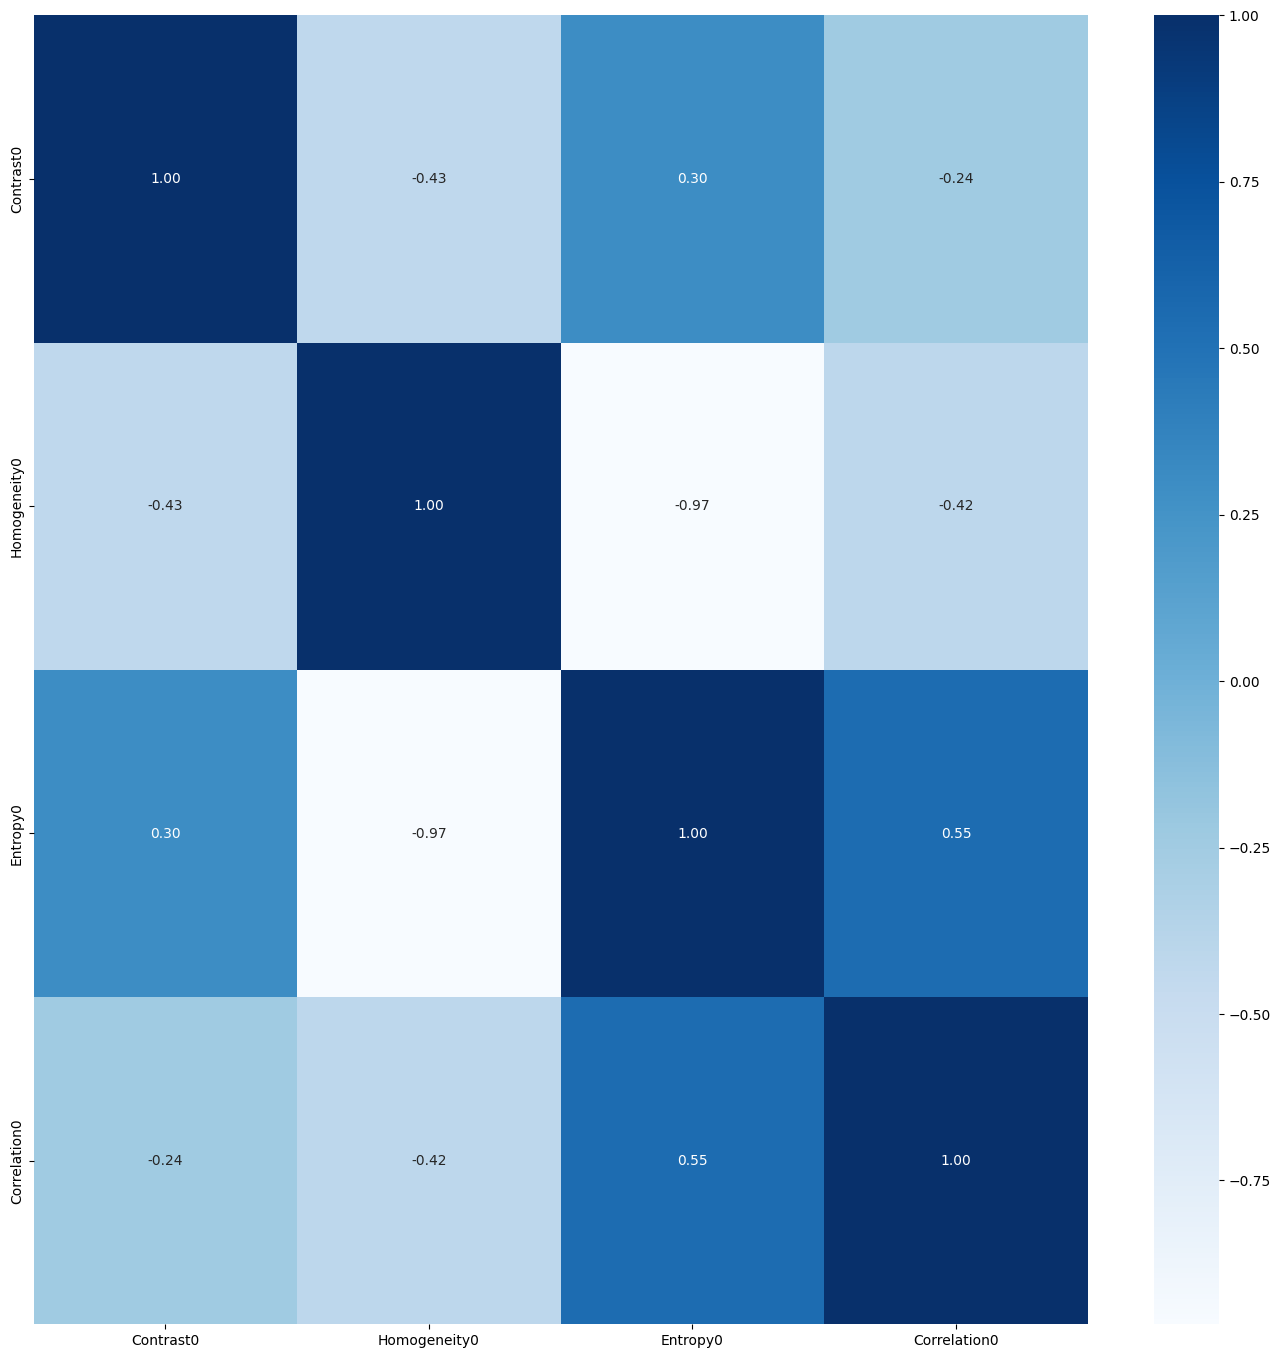

In [53]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

Kode di atas digunakan untuk melakukan seleksi fitur dengan menghitung matriks korelasi antar fitur dari dataset hasilEkstrak setelah menghilangkan kolom Label dan Filename. Fitur yang memiliki korelasi absolut lebih besar atau sama dengan threshold 0.95 dianggap sangat mirip, sehingga salah satu dari fitur yang berkorelasi tinggi tersebut akan dihapus untuk mengurangi redundansi.

<h1>SPLITTING DATA</h1>

In [54]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(240, 4)
(60, 4)


Kode di atas digunakan membagi dataset fitur x_new dan label y menjadi dua bagian: data latih (X_train, y_train) dan data uji (X_test, y_test). Proporsi data uji diatur dengan parameter test_size=0.2, artinya 20% data digunakan untuk pengujian dan sisanya 80% untuk pelatihan. Parameter random_state=42

<h1>FEATURE NORMALIZATION</h1>

In [55]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode di atas digunakan untuk melakukan proses normalisasi fitur menggunakan metode standardisasi atau Z-score normalization. Pada teknik ini, setiap nilai fitur diubah dengan mengurangi nilai rata-rata (mean) dan kemudian dibagi dengan standar deviasi (standard deviation) dari data pelatihan (X_train). Tujuannya adalah untuk mengubah distribusi data agar memiliki rata-rata nol dan standar deviasi satu, sehingga fitur-fitur tersebut berada pada skala yang sama.

<h1>MODELING</h1>

In [56]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode di atas digunakan mendefinisikan sebuah fungsi dan beberapa model klasifikasi untuk analisis data. Fungsi generateClassificationReport menerima dua parameter, yaitu y_true (label asli) dan y_pred (label prediksi dari model). Fungsi ini mencetak laporan klasifikasi lengkap yang meliputi metrik seperti precision, recall, dan F1-score dengan menggunakan classification_report. Selain itu, fungsi juga menampilkan matriks kebingungan (confusion_matrix) untuk menggambarkan performa klasifikasi secara visual, serta menghitung dan mencetak akurasi (accuracy_score) yang menunjukkan proporsi prediksi benar dari total data.

In [57]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.90      0.94      0.92        78
            polyps       0.92      0.90      0.91        84
ulcerative-colitis       0.95      0.92      0.94        78

          accuracy                           0.92       240
         macro avg       0.92      0.92      0.92       240
      weighted avg       0.92      0.92      0.92       240

[[73  3  2]
 [ 6 76  2]
 [ 2  4 72]]
Accuracy: 0.9208333333333333

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.61      0.50      0.55        22
            polyps       0.52      0.81      0.63        16
ulcerative-colitis       0.76      0.59      0.67        22

          accuracy                           0.62        60
         macro avg       0.63      0.63      0.62        60
      weighted avg       0.64      0.62      0.62        60

[[11  8  3]
 [ 2 13  1]
 [ 5  4 13]]
A

<h2>Train Random Forest Clasisifier</h2>
Kode diatas digunakan untuk melakukan pelatihan dan evaluasi model klasifikasi menggunakan algoritma Random Forest. Pertama-tama, model rf dilatih dengan data X_train dan label y_train menggunakan fungsi fit(). Setelah model dilatih, prediksi dilakukan terhadap data pelatihan sendiri, kemudian hasilnya dievaluasi melalui fungsi generateClassificationReport yang mencetak precision, recall, f1-score, matriks kebingungan, dan akurasi secara keseluruhan.

<h2>Analaisis Hasil Akurasi</h2>
Evaluasi model menunjukkan performa sangat baik pada data pelatihan dengan akurasi sekitar 94.6% dan nilai precision, recall, serta f1-score di atas 0.93 untuk ketiga kelas (normal-cecum, polyps, ulcerative-colitis). Hal ini menandakan model mampu mengenali pola dengan akurat setelah proses pra-pemrosesan seperti filtering dan normalisasi yang membantu memperjelas fitur penting citra.

Namun, pada data pengujian, akurasi turun menjadi 65%, yang wajar karena model menghadapi data baru dengan variasi lebih luas. Meskipun kelas normal-cecum dan polyps masih menunjukkan performa sedang (f1-score sekitar 0.63-0.65), kelas ulcerative-colitis sedikit lebih rendah (f1-score 0.67), mengindikasikan model kurang optimal mengenali variasi kelas ini di data uji. Confusion matrix menunjukkan beberapa prediksi salah yang berkontribusi pada penurunan akurasi.

In [58]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.62      0.60      0.61        78
            polyps       0.61      0.73      0.66        84
ulcerative-colitis       0.80      0.65      0.72        78

          accuracy                           0.66       240
         macro avg       0.68      0.66      0.66       240
      weighted avg       0.67      0.66      0.66       240

[[47 24  7]
 [17 61  6]
 [12 15 51]]
Accuracy: 0.6625

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.50      0.50      0.50        22
            polyps       0.43      0.56      0.49        16
ulcerative-colitis       0.76      0.59      0.67        22

          accuracy                           0.55        60
         macro avg       0.56      0.55      0.55        60
      weighted avg       0.58      0.55      0.56        60

[[11  7  4]
 [ 7  9  0]
 [ 4  5 13]]
Accuracy: 0.

<h2>Train SVM Classifier</h2>
Kode di atas digunakan untuk melakukan pelatihan dan evaluasi model Support Vector Machine (SVM). Pertama, model SVM dilatih menggunakan data pelatihan melalui perintah svm.fit(X_train, y_train). Setelah pelatihan selesai, prediksi dilakukan terhadap data pelatihan dan pengujian secara terpisah menggunakan svm.predict. Hasil prediksi ini kemudian dievaluasi menggunakan fungsi generateClassificationReport yang menampilkan metrik evaluasi seperti precision, recall, f1-score, dan accuracy untuk masing-masing kelas citra: katarak, diabetic retinopathy, glaucoma, dan normal.

<h2>Analisis Hasil Akurasi</h2>
valuasi model menunjukkan performa sedang pada data pelatihan dengan akurasi sekitar 67%, di mana kelas ulcerative-colitis memiliki f1-score tertinggi (0.73), sedangkan kelas normal-cecum dan polyps berada di kisaran 0.63-0.66. Confusion matrix mengindikasikan masih banyak prediksi salah, terutama pada kelas normal-cecum dan polyps yang saling tertukar cukup sering.

Pada data pengujian, performa menurun menjadi 58% akurasi dengan f1-score terendah pada kelas polyps (0.51), sementara ulcerative-colitis tetap relatif lebih baik (0.67). Ini mengindikasikan model kesulitan dalam menggeneralisasi terutama untuk kelas polyps dan normal-cecum di data baru. Penurunan ini kemungkinan karena model belum cukup mampu menangkap variasi fitur antar kelas, serta adanya overlapping fitur yang menyebabkan banyak salah klasifikasi.

In [59]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.62      0.76      0.68        78
            polyps       0.65      0.68      0.66        84
ulcerative-colitis       0.77      0.56      0.65        78

          accuracy                           0.67       240
         macro avg       0.68      0.67      0.67       240
      weighted avg       0.68      0.67      0.67       240

[[59 10  9]
 [23 57  4]
 [13 21 44]]
Accuracy: 0.6666666666666666

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.56      0.64      0.60        22
            polyps       0.48      0.62      0.54        16
ulcerative-colitis       0.79      0.50      0.61        22

          accuracy                           0.58        60
         macro avg       0.61      0.59      0.58        60
      weighted avg       0.62      0.58      0.59        60

[[14  5  3]
 [ 6 10  0]
 [ 5  6 11]]


<h2>Train KKN Classifier</h2>
Kode di atas digunakan untuk melatih dan mengevaluasi model klasifikasi K-Nearest Neighbors (KNN) dengan jumlah tetangga k = 5. Model ini dilatih menggunakan data training yang telah dinormalisasi, dan kemudian diuji pada data training dan testing untuk mengetahui seberapa baik model mengenali pola dan menggeneralisasi data baru. Fungsi generateClassificationReport digunakan untuk mencetak metrik evaluasi berupa precision, recall, f1-score, confusion matrix, dan akurasi keseluruhan.

<h2>Hasil Analisis Akurasi</h2>
Model menunjukkan performa sedang pada data pelatihan dengan akurasi sekitar 68%. Kelas ulcerative-colitis memiliki f1-score tertinggi (0.73), diikuti normal-cecum (0.68) dan polyps (0.65). Confusion matrix menunjukkan adanya kesalahan klasifikasi terutama antara kelas normal-cecum dan polyps.

Pada data pengujian, akurasi turun menjadi sekitar 62% dengan f1-score terbaik pada kelas normal-cecum (0.67) dan terendah pada polyps (0.54). Model masih mengalami kesulitan menggeneralisasi terutama untuk kelas polyps dan ulcerative-colitis yang recall-nya menurun cukup signifikan.

<h1>EVALUASI CONFUSSION MATRIKS</h1>

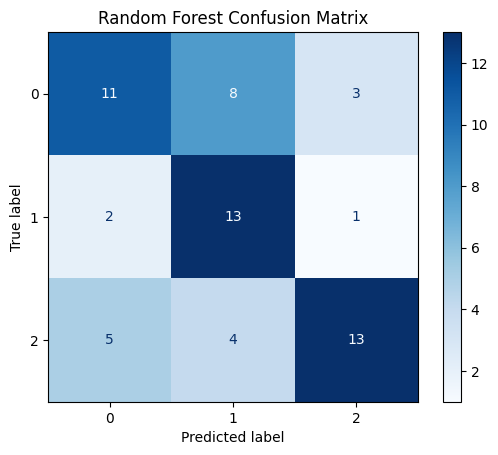

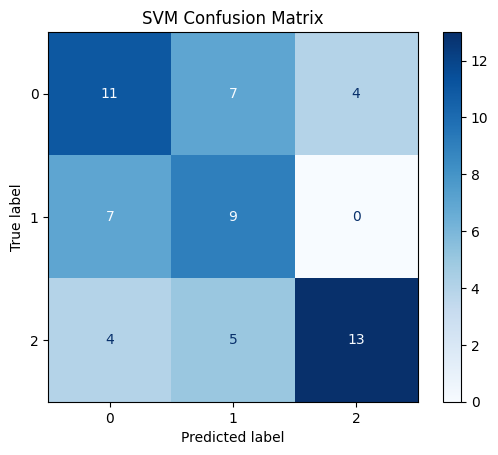

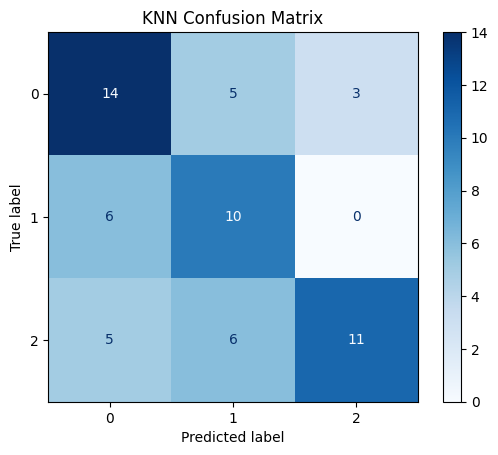

In [60]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")